In [63]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from astral.geocoder import database, lookup
from astral.sun import daylight

# Load the data

In [64]:
base_path = "."
destination_data_h5_path = os.path.join(base_path, "..", "datasets", "SolarEnergyProduction.h5")
source_data = os.path.join(base_path, "data", "SolarEnergyProduction", "Solar_Energy_Production.csv")

In [65]:
df = pd.read_csv(source_data)
print(df.shape)
df['date'] = pd.to_datetime(df['date'])
df.head()

(258423, 8)


,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 08:00:00,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 09:00:00,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 10:00:00,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 11:00:00,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 12:00:00,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


# Add number of daylight hours

In [66]:
astral_db = database()
calgary_info = lookup("Calgary", astral_db)

def daylight_hours(row, feature_name='date'):
    time_sunrise, time_sunset = daylight(calgary_info.observer, row[feature_name], tzinfo=calgary_info.timezone)
    return (time_sunset - time_sunrise).total_seconds() / 3600

In [67]:
# # add number of daylight hours to each row
# df['daylight_hours'] = df.apply(daylight_hours, axis=1)
# df.head()

# Group by day

In [68]:
df['day_period'] = df['date'].dt.to_period('D')

daily = df.groupby(['day_period', 'id'])['kWh'].sum().to_frame().reset_index()
daily['date'] = daily['day_period'].dt.to_timestamp()
daily.drop(columns=['day_period'], inplace=True)
daily['daylight_hours'] = daily.apply(lambda x: daylight_hours(x, 'date'), axis=1)
print(daily.shape)
daily.head()

(20988, 4)


,id,kWh,date,daylight_hours
0,164440,286.013,2015-09-01,13.533085
1,164440,681.646,2015-09-02,13.470491
2,164440,647.906,2015-09-03,13.407756
3,164440,102.448,2015-09-04,13.344890
4,164440,93.432,2015-09-05,13.281901


# Group by month

In [69]:
monthly = daily.groupby([daily['date'].dt.to_period('M'), 'id'])[['kWh', 'daylight_hours']].sum().reset_index()
print(monthly.shape)
monthly.head()

(739, 4)


,date,id,kWh,daylight_hours
0,2015-09,164440,15475.746,353.669296
1,2015-10,164440,15068.149,330.919331
2,2015-11,164440,4302.924,267.965801
3,2015-12,164440,1722.964,231.892523
4,2016-01,164440,3081.863,263.193197


# Save the data

In [70]:
daily.to_hdf(destination_data_h5_path, key='daily', mode='w')
monthly.to_hdf(destination_data_h5_path, key='monthly', mode='a')

TypeError: objects of type ``PeriodArray`` are not supported in this context, sorry; supported objects are: NumPy array, record or scalar; homogeneous list or tuple, integer, float, complex or bytes

# Plot the data

ValueError: label must be scalar or have the same length as the input data, but found 1 for 2 datasets.

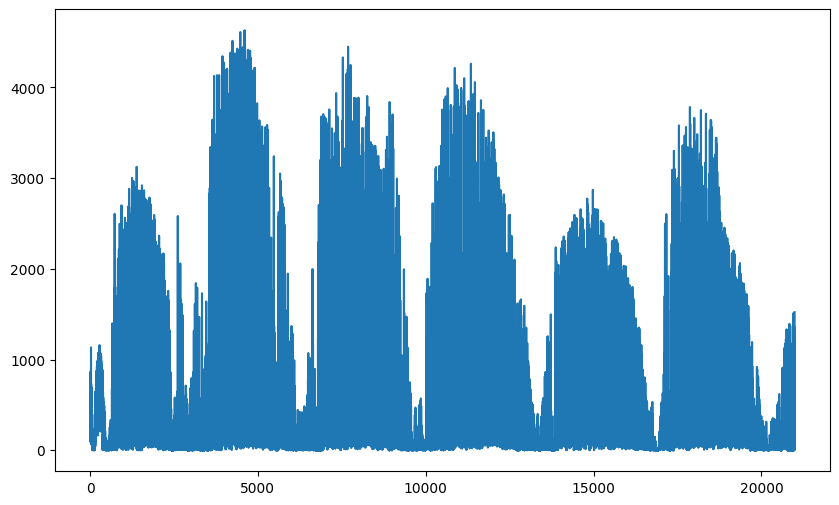

In [72]:
plt.figure(figsize=(10,6))
plt.plot(daily[['kWh']], label=['kWh'])
plt.plot(daily[['kWh']]/daily[['daylight_hours']], label=['kWh normalized'])
plt.title('Daily')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()